In [1]:
import torch
from torch import nn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/student_exam_data_new.csv")
df.head(2)

,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1


In [3]:
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)

In [4]:
X = df_train[["Study Hours", "Previous Exam Score"]].values

In [5]:
X[:10]

array([[ 6.78959397, 67.19733008],
       [ 8.33915286, 77.32520201],
       [ 1.64069784, 41.52318134],
       [ 3.17849744, 47.65481817],
       [ 9.16809827, 47.23815227],
       [ 4.06723186, 80.08510819],
       [ 1.20944742, 79.53543651],
       [ 3.05141646, 77.09528629],
       [ 1.67095579, 94.24952167],
       [ 7.99432224, 76.03101163]])

In [6]:
y = df_train["Pass/Fail"].values

In [7]:
y[:10]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [8]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [9]:
X.shape

torch.Size([400, 2])

## For the network we want 10 hidden neurons and 1 output neuron where the output of the 10 neurons will be passed to the output neuron which gives the output

In [10]:
hidden_neuron = nn.Linear(2, 10)
output_neuron = nn.Linear(10, 1)

In [11]:
list(hidden_neuron.parameters())

[Parameter containing:
 tensor([[ 0.2756, -0.0374],
         [-0.0728, -0.0313],
         [ 0.1701,  0.1459],
         [-0.6822, -0.1375],
         [ 0.0215,  0.6895],
         [ 0.1869, -0.5999],
         [ 0.5813,  0.1218],
         [ 0.6823, -0.1400],
         [-0.5391, -0.3407],
         [-0.5617,  0.5147]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1986, -0.1200, -0.1792,  0.5540,  0.6138, -0.2071,  0.3741, -0.3474,
         -0.3601, -0.3638], requires_grad=True)]

In [12]:
total_parameters = list(hidden_neuron.parameters()) + list(output_neuron.parameters())

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(total_parameters, lr=0.005)

In [14]:
losses = []
for i in tqdm(range(500000)):
    optimizer.zero_grad()
    hidden_outputs = hidden_neuron(X)
    final_hidden_output = nn.functional.sigmoid(hidden_outputs) #Normalize the outputs from the hidden layer
    final_output = output_neuron(final_hidden_output)
    loss = loss_fn(final_output, y)
    if i % 100 == 0:
        losses.append(loss.item())
    loss.backward()
    optimizer.step()

100%|█████████████| 500000/500000 [24:42<00:00, 337.37it/s]


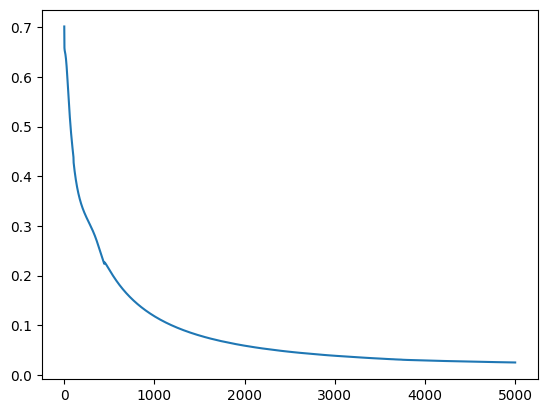

In [15]:
plt.plot(losses)

In [16]:
import os

os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

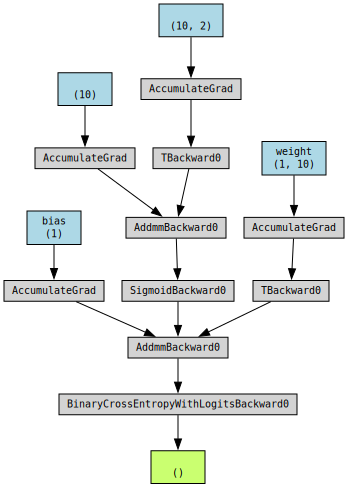

In [17]:
from torchviz import make_dot

make_dot(
    loss,
    params=dict(
        list(hidden_neuron.named_parameters()) +
        list(output_neuron.named_parameters())
    )
)

In [18]:
test_x = df_test[["Study Hours", "Previous Exam Score"]].values
test_y = df_test["Pass/Fail"].values

In [19]:
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32).reshape(-1, 1)

In [20]:
test_y.shape

torch.Size([100, 1])

In [21]:
hidden_neuron.eval()
output_neuron.eval()
with torch.no_grad():
    hidden_outputs = hidden_neuron(test_x)
    final_hidden_output = nn.functional.sigmoid(hidden_outputs) #Normalize the outputs from the hidden layer
    final_output = output_neuron(final_hidden_output)
    y_pred = nn.functional.sigmoid(final_output) > 0.15
    y_pred = y_pred.reshape(-1, 1).type(torch.float32) 
    print(y_pred.shape)
    accuracy = (y_pred == test_y).type(torch.float32).mean()
    print(f"Accuracy: {accuracy.item()}")

torch.Size([100, 1])
Accuracy: 0.949999988079071
